### A szükséges csomagok importálása

In [2]:
import torch
import numpy as np
from PIL import Image
import json
from transformers import SiglipProcessor, SiglipModel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.manifold import TSNE
import umap
from umap import UMAP

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Betöltjük, ami majd kelleni fog

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Ezek a modellek jók 512 tokenig
model = SiglipModel.from_pretrained("google/siglip-base-patch16-224").to(device)
processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")

# Ezek az előre kiszámolt embeddingek és kép infók (fontos, hogy párba legyenek a modellekkel)
embeddings = torch.load("C:/Users/Adam/Desktop/applied_ml/dataset/image_embeddings_siglip.pt")
infos = torch.load("C:/Users/Adam/Desktop/applied_ml/dataset/image_info_siglip.pt")

# A képcsoportokról szóló szövegek betöltése
with open("C:/Users/Adam/Desktop/applied_ml/custom_captions.json", encoding="utf-8") as f:
    class_texts = json.load(f)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
C:\Users\Adam\AppData\Local\Temp\ipykernel_8704\1568696297.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by

### Itt tetszés szerint lehet szövegeket beadni neki

In [6]:
query = """
        "The tree poppy has large, crinkled white petals that are thin, delicate, and slightly translucent.",
        "Its petals resemble wrinkled tissue paper or creased silk, often overlapping loosely in an open, wide arrangement.",
        "The flower has a bold yellow or orange central disk that is round, slightly raised, and densely textured with stamens.",
        "Each bloom typically features five to six broad petals arranged around the central disk in a simple radial pattern.",
        "The center stands out in contrast against the clean white of the petals, creating a strong two-tone appearance.",
        "The petals tend to droop or bend gently downward, giving the flower a soft, relaxed silhouette.",
        "Tree poppies often grow singly on long green stems, surrounded by sparse, gray-green or silvery foliage.",
        "In many images, the flower appears quite large compared to the surrounding leaves or buds.",
        "Some petals are torn or uneven at the edges, enhancing the natural, airy look of the bloom.",
        "Overall, the tree poppy is defined by its papery white petals and golden-yellow center, with a fragile and luminous appearance."
"""

### De használhatjuk a meglévőeket is

In [9]:
query = " ".join(class_texts["68"])
print(query)

Bearded iris flowers display six petal-like tepals in a striking arrangement: three upright 'standards' and three cascading 'falls' that flare outward dramatically. The falls often feature a dense, velvety texture with vivid central striping or veining, and most notably, a fuzzy, caterpillar-like 'beard' of short hairs running along the centerline. Colors range widely from deep royal purple, violet, and blue to white, yellow, peach, and intricate bi-color combinations with contrasting throats and edges. The beard may be golden, white, or orange, often standing out boldly against the darker falls and enhancing the flower’s complex visual structure. The standards are usually ruffled or slightly curled, rising vertically and giving the flower a regal, three-dimensional crown-like shape. The falls droop elegantly and may also exhibit intricate frills, speckling, or color gradients that shift from base to edge, sometimes mimicking brushstroke-like patterns. Each bloom emerges on tall, erect

### A szöveghez a modell szerint leginkább hasonlító k darab kép

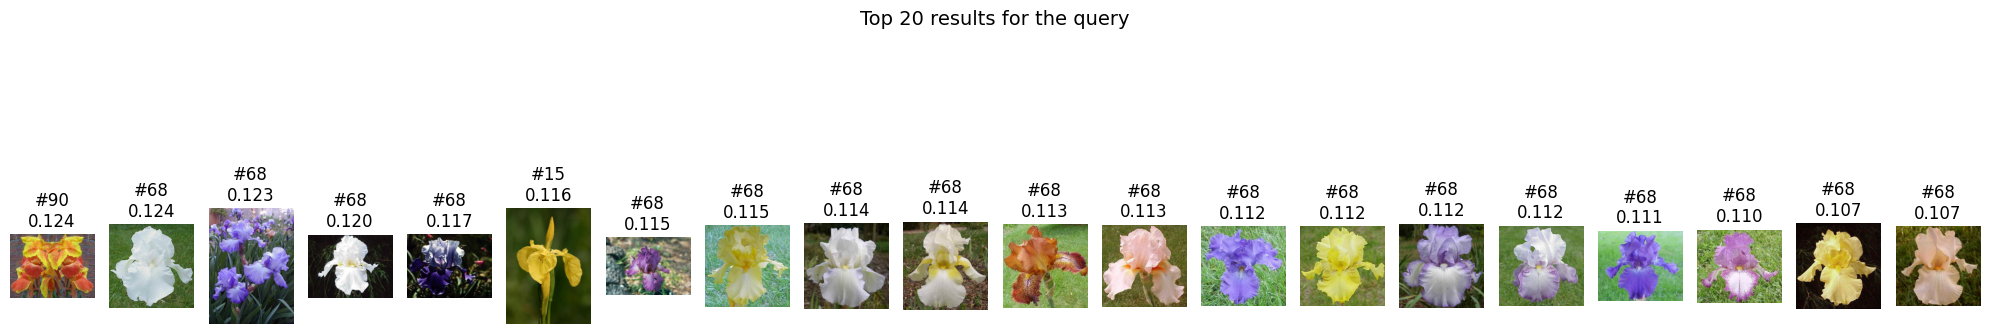

In [10]:
top_k = 20

inputs = processor(text=[query], return_tensors="pt", padding=True, truncation=True).to(device) # Ennek a cellának ez a sor a lelke: előfeldolgozza és tensor formátumba hozza a query-t
with torch.no_grad():
    text_feat = model.get_text_features(**inputs)   # Itt készül az embedding vektor
    text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True) # Itt lesz egység hosszú a vektor
    text_feat = text_feat.cpu()

# Cos_sim számítás a képek embeddingje és a szövegünk embeddingje között
similarities = torch.matmul(embeddings, text_feat.T).squeeze()

top_scores, top_indices = similarities.topk(top_k)  # A lekérdezéshez legjobban illeszkedő képek kiválasztása

fig, axes = plt.subplots(1, top_k, figsize=(20, 5))
for i, idx in enumerate(top_indices):
    img_path = infos[idx]["path"]
    label = infos[idx]["label"]
    score = top_scores[i].item()

    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"#{label}\n{score:.3f}") # A képek fölé a cos_sim érték és az osztáylcímke
    axes[i].axis("off")

plt.suptitle(f"Top {top_k} results for the query", fontsize=14)
plt.tight_layout()
plt.show()

### Itt csak a szövegek feldolgozása zajlik

In [8]:
text_features = [] # Egy lista a leképezett szövegeknek
labels = [] # Egy pedig a hozzájuk tartozó class_id-knak

for class_id, texts in tqdm(class_texts.items(), desc="Szövegek feldolgozása"): # For ciklus az id-szöveg párokon
    if isinstance(texts, list):
        combined_text = " ".join(texts) # Össze kell fűzni a sorokat
    else:
        combined_text = texts

    inputs = processor(text=[combined_text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_feat = model.get_text_features(**inputs)
        text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

    text_features.append(text_feat.cpu())
    labels.append(class_id)

# Stackelés
text_features = torch.cat(text_features, dim=0) # Összes embedding egy nagy mátrixba

Szövegek feldolgozása: 100%|██████████| 102/102 [00:02<00:00, 37.67it/s]


### Az összes szöveg 2D-ben a t-SNE szerint

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Adam\miniconda3\envs\main_env\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Adam

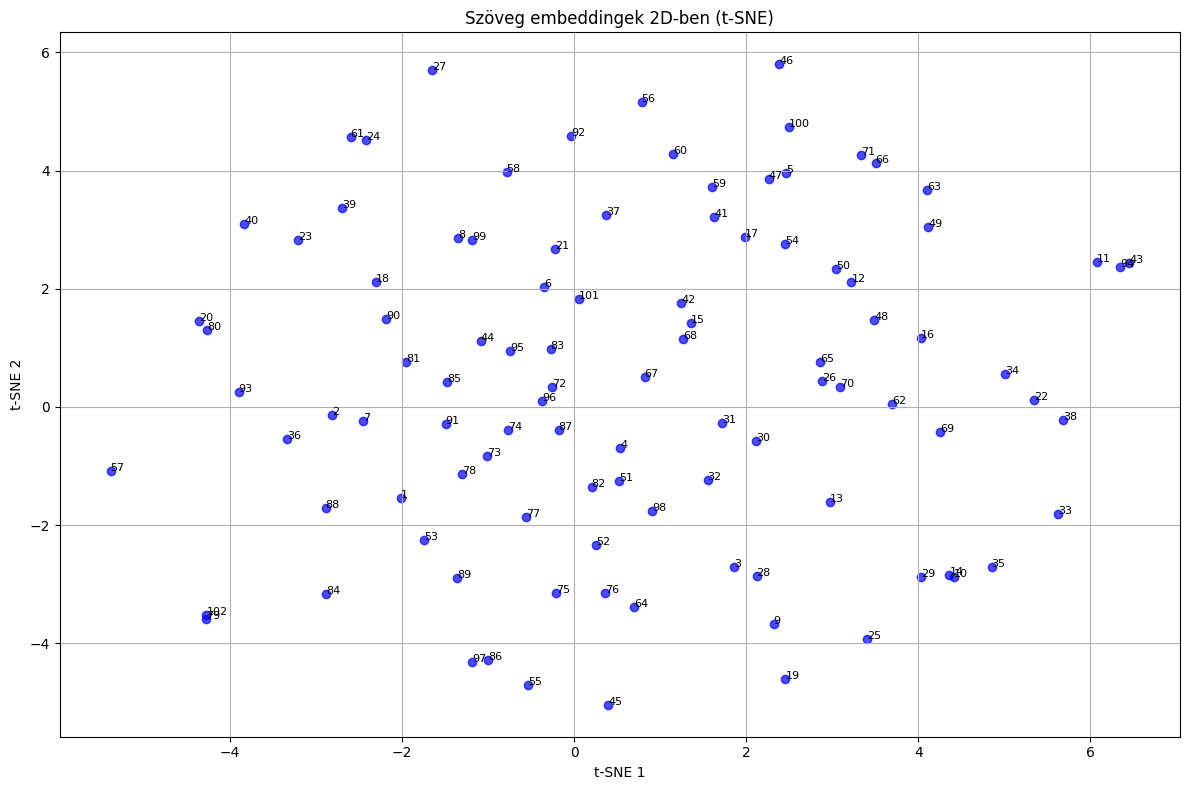

In [6]:
reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000) # Egy beállított t-SNE modell
text_2d = reducer.fit_transform(text_features.numpy())  # Ez futtatja a dimenziócsökkentést

plt.figure(figsize=(12, 8))
plt.scatter(text_2d[:, 0], text_2d[:, 1], c='blue', alpha=0.7)

for i, label in enumerate(labels):
    plt.text(text_2d[i, 0], text_2d[i, 1], label, fontsize=8)

plt.title("Szöveg embeddingek 2D-ben (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Az összes szöveg 2D-ben a UMAP szerint 

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


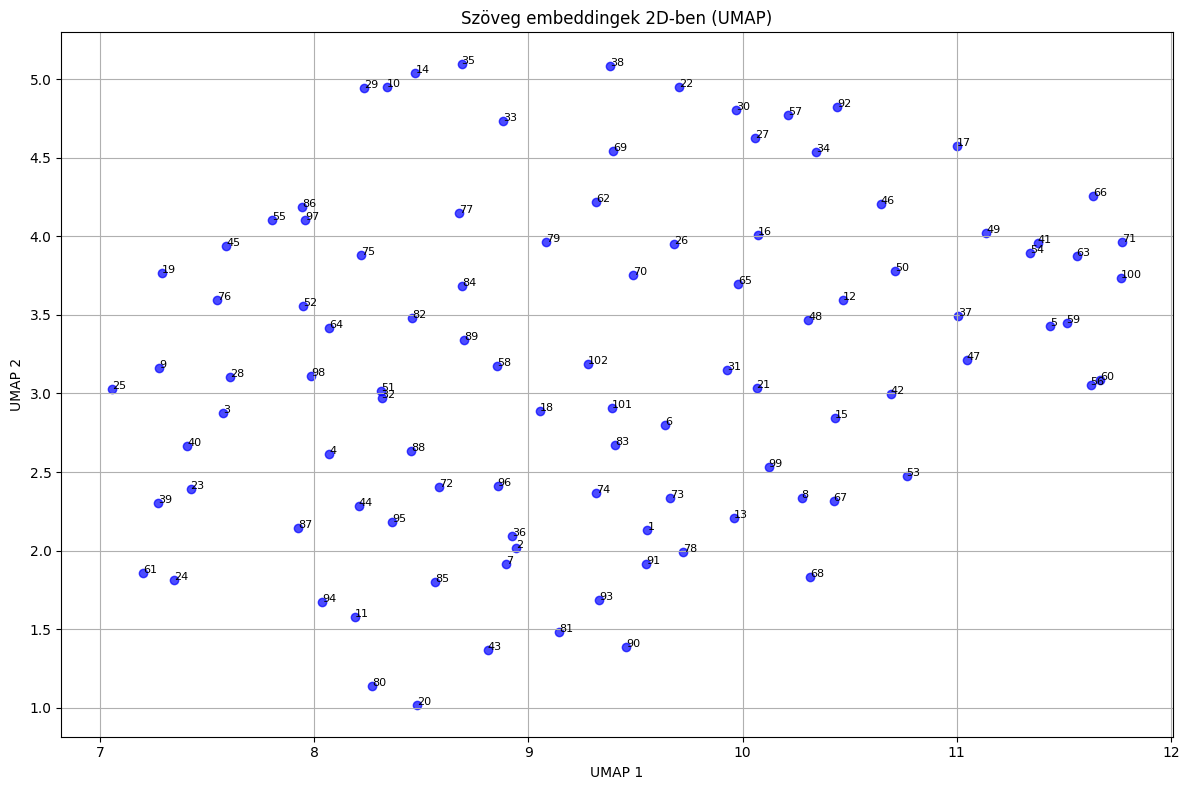

In [7]:
# Ugyanaz UMAP-pel
reducer = umap.UMAP(n_components=2, random_state=42)
text_2d = reducer.fit_transform(text_features.numpy())

plt.figure(figsize=(12, 8))
plt.scatter(text_2d[:, 0], text_2d[:, 1], c='blue', alpha=0.7)

for i, label in enumerate(labels):
    plt.text(text_2d[i, 0], text_2d[i, 1], label, fontsize=8)

plt.title("Szöveg embeddingek 2D-ben (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Az összes kép centroidjának plotolása, valamint egy szöveg kiválasztása és ...

In [ ]:
target_class = "70"

class_to_embeddings = {}  # Ebben a szótárban gyűjtjük a képekhez tartozó embeddingeket
for idx, info in enumerate(infos):  # Az infos-ban metaadatok vannak... label, path, stb.
    label = str(info['label'])
    if label not in class_to_embeddings:
        class_to_embeddings[label] = []
    class_to_embeddings[label].append(embeddings[idx].unsqueeze(0))  # 1 dimenziót hozzáadunk (batch dimenzió), hogy könnyebb legyen később összefűzni

class_centroids = {}
for label, embs in class_to_embeddings.items():
    embs_tensor = torch.cat(embs, dim=0)  # 1*d vektorokból csinál n*d alakút
    centroid = embs_tensor.mean(dim=0)  # Oszloponként vesz átlagot
    centroid = centroid / centroid.norm()
    class_centroids[label] = centroid

query = "\n".join(class_texts[target_class])  

inputs = processor(text=[query], return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    text_embedding = text_embedding / text_embedding.norm(p=2, dim=-1, keepdim=True)
    text_embedding = text_embedding.cpu().squeeze()

all_centroids = torch.stack(list(class_centroids.values()))
labels = list(class_centroids.keys())
combined_embeddings = torch.vstack([all_centroids, text_embedding]) # Centroidok + szöveg embedding összevonása

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


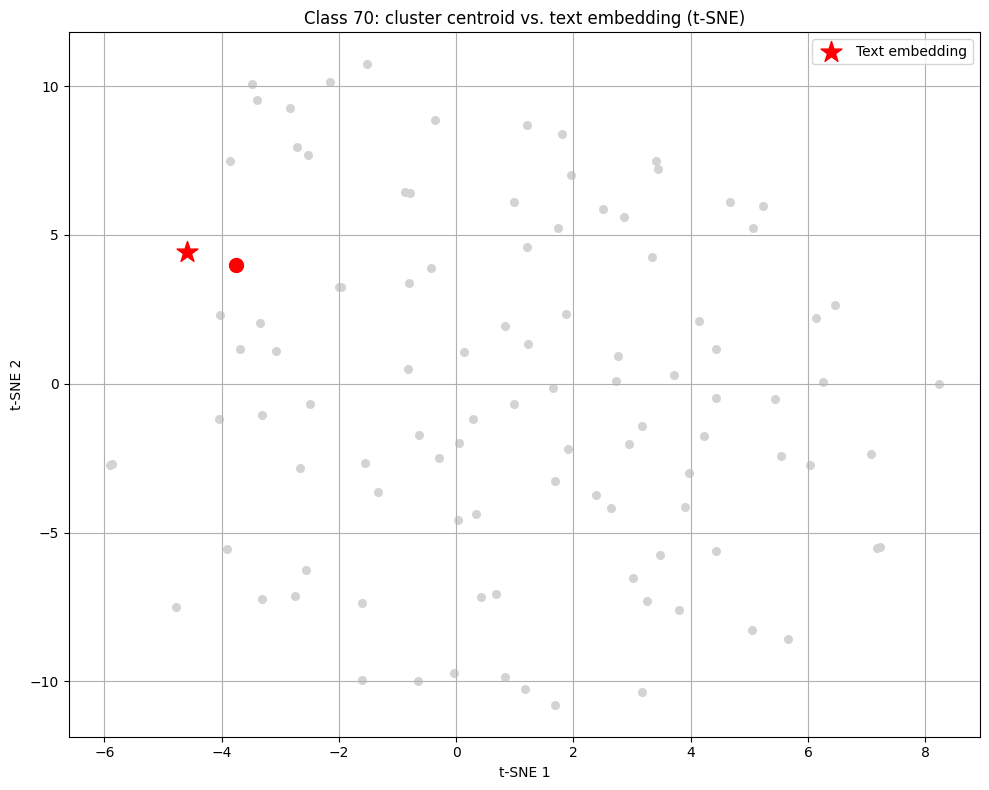

In [9]:
reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
combined_2d = reducer.fit_transform(combined_embeddings.numpy()) # Itt fontos, hogy ez a combined_embeddings-en fusson

centroids_2d = combined_2d[:-1, :]  # Az első N pont a centroidok
text_2d = combined_2d[-1, :]        # Az utolsó pont a szöveg embedding

plt.figure(figsize=(10, 8))

# Minden klaszter középpont szürkével, kivéve a kiválasztott
for i, label in enumerate(labels):
    color = 'red' if label == target_class else 'lightgray'
    size = 100 if label == target_class else 30
    plt.scatter(centroids_2d[i, 0], centroids_2d[i, 1], color=color, s=size)

plt.scatter(text_2d[0], text_2d[1], color='red', marker='*', s=250, label='Text embedding') # Szöveg embedding csillaggal

plt.legend()
plt.title(f"Class {target_class}: cluster centroid vs. text embedding (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Ugyanaz csak most UMAP-pel

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


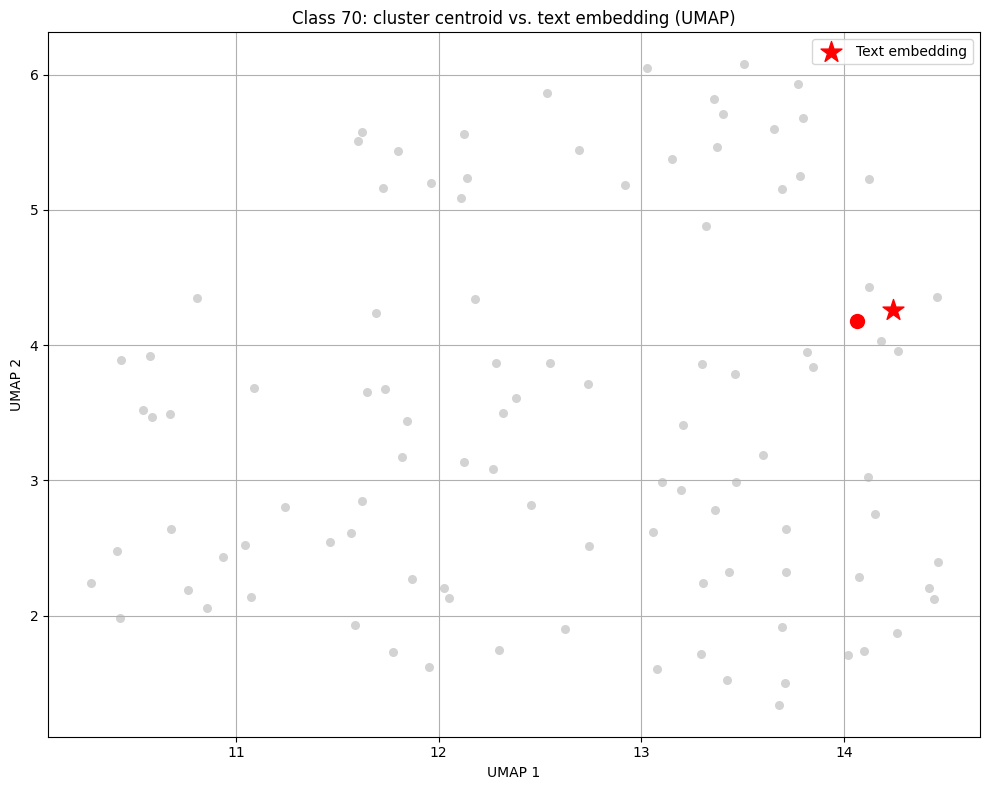

In [10]:
reducer = umap.UMAP(n_components=2, random_state=42)
combined_2d = reducer.fit_transform(combined_embeddings.numpy())

centroids_2d = combined_2d[:-1, :]  # Az első N pont: klaszter középpontok
text_2d = combined_2d[-1, :]        # Az utolsó pont: szöveg embedding

plt.figure(figsize=(10, 8))

# Minden klaszter középpont
for i, label in enumerate(labels):
    color = 'red' if label == target_class else 'lightgray'
    size = 100 if label == target_class else 30
    plt.scatter(centroids_2d[i, 0], centroids_2d[i, 1], color=color, s=size)


plt.scatter(text_2d[0], text_2d[1], color='red', marker='*', s=250, label='Text embedding') 

plt.legend()
plt.title(f"Class {target_class}: cluster centroid vs. text embedding (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Itt már csak egy képosztállyal foglalkozunk

In [11]:
# target_class = 

# Képek szűrése
target_indices = [i for i, info in enumerate(infos) if info['label'] == target_class]
target_image_embeddings = embeddings[target_indices]  # ez szedi ki a mátrixból a megfelelő embeddingeket

text_lines = class_texts[target_class]
if isinstance(text_lines, list):
    full_text = " ".join(text_lines)
else:
    full_text = text_lines

inputs = processor(text=[full_text], return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    text_embedding = text_embedding / text_embedding.norm(p=2, dim=-1, keepdim=True)
    text_embedding = text_embedding.cpu()

all_embeddings = torch.cat([target_image_embeddings, text_embedding], dim=0)

### t-SNE szerint ez így néz ki

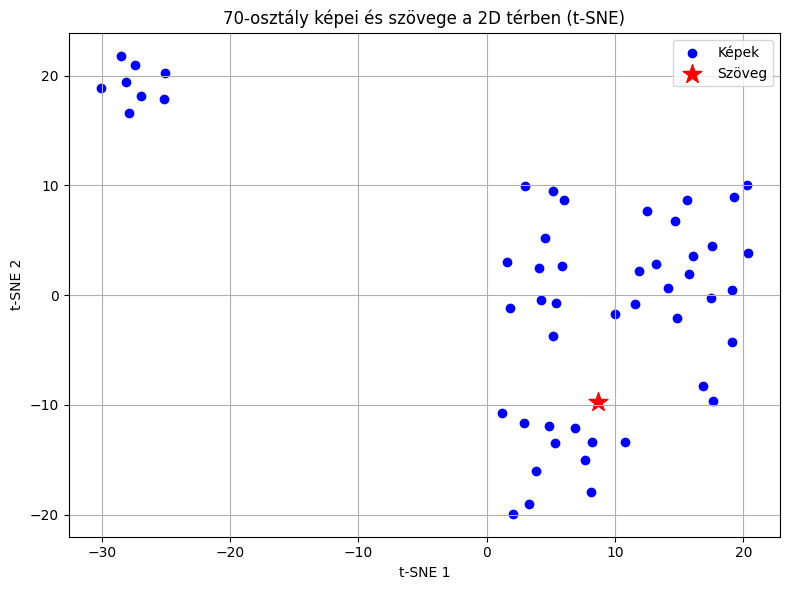

In [12]:
tsne = TSNE(n_components=2, random_state=42, perplexity=7)
embeddings_2d = tsne.fit_transform(all_embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', label="Képek")
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', marker='*', s=200, label="Szöveg")
plt.legend()
plt.title(f"{target_class}-osztály képei és szövege a 2D térben (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### UMAP szerint így nézne ki

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


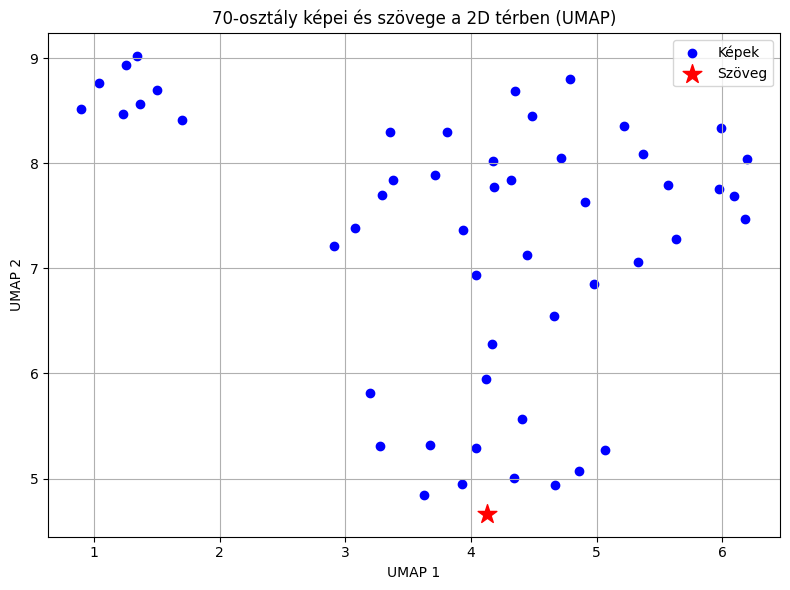

In [13]:
reducer = UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(all_embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:-1, 0], embeddings_2d[:-1, 1], c='blue', label="Képek")
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], c='red', marker='*', s=200, label="Szöveg")
plt.legend()
plt.title(f"{target_class}-osztály képei és szövege a 2D térben (UMAP)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()

### Itt azt nézzük meg, hogy egy adott szöveg embeddinghez mely képek vannak legközelebb (mint a top_k fényképes cella), csak most megkérjük az UMAP-et, hogy 2D-be ezt plotolja nekünk.  
Annyi "extra" van benne, hogy vizuálisan értelmezhetővé szerettük volna tenni, hogy mennyire is jó a vetítés kisebb dimenzióba  
* A piros csillag jelzi a szövegünk embeddingjét a látens térben
* A fekete pöttyök azok a képek, melyek a helyes osztályba tartoznak (abba amiről a szöveg hivatott beszélni) és nincs náluk hasonlóbb más osztálybeli kép  
* A sárga háromszögek olyan, a helyes osztályba tartozó képek, melyeknél van a szöveghez jobban illeszkedő más osztálybeli kép (szóval ezek már az első félreklasszifikáció után vannak a felsorolásba)  
* A többi színes pont pedig azoknak a képeknek az embeddingjei, melyek valamiért jobban hasonlítanak a szövegre, mint azok a képek, amlyekről ténylegesen a szöveg szólna (szóval a ténylegesen félreklasszifikáltak)

In [14]:
# Itt lényegében csak eddig használt kódok vannak

target_class = "1"
number_of_plotted_pics = 60

text = " ".join(class_texts[target_class])
inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    text_embedding = model.get_text_features(**inputs)
    text_embedding = text_embedding / text_embedding.norm(p=2, dim=-1, keepdim=True)
    text_embedding = text_embedding.cpu().squeeze()

similarities = torch.matmul(embeddings, text_embedding)

top_scores, top_indices = similarities.topk(number_of_plotted_pics)
selected_embeddings = embeddings[top_indices]
selected_labels = [str(infos[i]['label']) for i in top_indices]

### Itt az idegen osztályokhoz rendelünk színeket

In [15]:
classified = []
label_set = sorted(set(selected_labels) - {target_class}) # Csak az idegen osztályokat gyűjti ki
color_map = cm.get_cmap('tab20', len(label_set))  # max 20 osztályhoz lesz elég szín

label_to_color = {label: color_map(i) for i, label in enumerate(label_set)} # Itt csak színeket rendelünk az idegen osztályokhoz

for i, idx in enumerate(top_indices):   # Ezzel a ciklussal olvassuk ki a top k db kép címkéjét és cos_sim értékét
    this_label = str(infos[idx]["label"])
    this_score = similarities[idx].item()   

    if this_label == target_class:
        closer_exists = False
        for j in range(len(similarities)):
            if str(infos[j]["label"]) != target_class and similarities[j] > similarities[idx]: # Ezzel azt nézzük meg, hogy van-e olyan idegen osztályú kép, ami közelebb van a szöveg embeddinghez, mint a helyes kép
                closer_exists = True
                break
        if closer_exists:
            classified.append("confused") # Ha volt, akkor már félre van klasszifikálva legalább egy kép és onnantól borult a tökéletes megoldás
        else:
            classified.append("correct") # Ha nem, akkor minden jó
    else:
        classified.append(this_label)

C:\Users\Adam\AppData\Local\Temp\ipykernel_7576\3171372942.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(label_set))  # max 20 osztályhoz lesz elég szín


### Itt peddig már csak az ábrázolás van hátra

c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Adam\miniconda3\envs\main_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


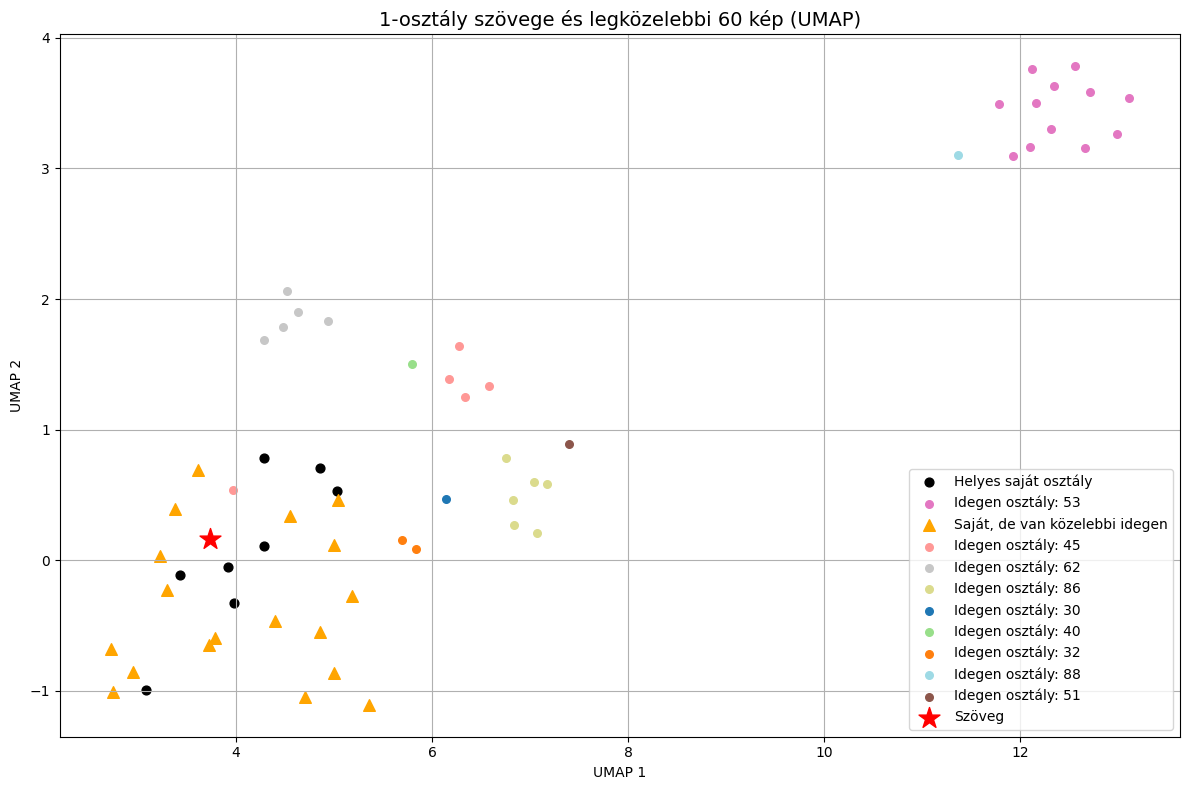

In [16]:
all_points = torch.cat([selected_embeddings, text_embedding.unsqueeze(0)], dim=0)
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(all_points.numpy())

image_points_2d = embeddings_2d[:-1]
text_point_2d = embeddings_2d[-1]

plt.figure(figsize=(12, 8))

# Plotolunk kategóriák szerint
for i, cls in enumerate(classified):
    if cls == "correct":
        plt.scatter(image_points_2d[i, 0], image_points_2d[i, 1], color="black", label="Helyes saját osztály" if "Helyes saját osztály" not in plt.gca().get_legend_handles_labels()[1] else "", s=40)
    elif cls == "confused":
        plt.scatter(image_points_2d[i, 0], image_points_2d[i, 1], color="orange", marker="^", label="Saját, de van közelebbi idegen" if "Saját, de van közelebbi idegen" not in plt.gca().get_legend_handles_labels()[1] else "", s=70)
    else:
        color = label_to_color.get(cls, "gray")
        label_name = f"Idegen osztály: {cls}"
        if label_name not in plt.gca().get_legend_handles_labels()[1]:
            plt.scatter(image_points_2d[i, 0], image_points_2d[i, 1], color=color, label=label_name, s=30)
        else:
            plt.scatter(image_points_2d[i, 0], image_points_2d[i, 1], color=color, s=30)

plt.scatter(text_point_2d[0], text_point_2d[1], color="red", marker="*", s=250, label="Szöveg")

plt.title(f"{target_class}-osztály szövege és legközelebbi {number_of_plotted_pics} kép (UMAP)", fontsize=14)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Ebből lényegében szerintünk elég egyértelműen látható, hogy bármennyire is szeretnénk belevetíteni a magas dimenziós teret egy 2 dimenziósba, annak erősen meglesznek a korlátai. Szinte bármilyen target-et is válasszunk lesz olyan, hogy a plot-on fekete pont fog megjelenni (azaz helyes osztályú kép embedding magas cos_sim értékkel) olyan helyen, ami (láthatóan) távolabb van a szöveg embeddingtől, mint egy más osztályba tartozó kép embeddingje (ami ugye kizárja azt, hogy az előző fekete legyen, hisz az "távolabb volt", de ugye csak 2D-ben). És visszafele ugyanez, lesz olyan sárga háromszög (azaz helyes osztályú kép embedding magas cos_sim értékkel, aminél viszont van helyesebb más osztálybeli kép), amelyik közelebb van a szöveg embeddinghez, mint a más osztálybeli kép, ami miatt ő sárga háromszög lett.  
* Mellette szól viszont, hogy a klaszterek szépen kirajzolódnak, ezt valószínű fogjuk tudni a jövőben használni
* A tengelyeken látható számoknak pedig nincs abszolút jelentésük, csak relatív viszonyokat kódolnak.